In [1]:
!unzip ly_count_dens_map.zip

Archive:  ly_count_dens_map.zip
   creating: ly_count_dens_map/
  inflating: ly_count_dens_map/.DS_Store  
  inflating: __MACOSX/ly_count_dens_map/._.DS_Store  
  inflating: ly_count_dens_map/LICENSE  
  inflating: __MACOSX/ly_count_dens_map/._LICENSE  
  inflating: ly_count_dens_map/requirements.txt  
  inflating: __MACOSX/ly_count_dens_map/._requirements.txt  
  inflating: ly_count_dens_map/data_loader.py  
  inflating: __MACOSX/ly_count_dens_map/._data_loader.py  
  inflating: ly_count_dens_map/looper.py  
  inflating: __MACOSX/ly_count_dens_map/._looper.py  
  inflating: ly_count_dens_map/get_data.py  
  inflating: __MACOSX/ly_count_dens_map/._get_data.py  
  inflating: ly_count_dens_map/model.py  
  inflating: __MACOSX/ly_count_dens_map/._model.py  
  inflating: ly_count_dens_map/README.md  
  inflating: __MACOSX/ly_count_dens_map/._README.md  
  inflating: ly_count_dens_map/train.py  
  inflating: __MACOSX/ly_count_dens_map/._train.py  


In [2]:
!pip install -r dens_map/requirements.txt


     |████████████████████████████████| 81kB 6.5MB/s 
  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=8476e57be58537e835ad91b48d9b55d1642a1da71d2f0e2415f0b52c25dcec1f
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
  Created wheel for typing: filename=typing-3.7.4.3-cp36-none-any.whl size=26307 sha256=aa457d85690a9d98a755852852634e288d02c22427f9187b58d1f86ce0c22514
  Stored in directory: /root/.cache/pip/wheels/2d/04/41/8e1836e79581989c22eebac3f4e70aaac9af07b0908da173be
Successfully built wget typing


In [1]:
!python dens_map/get_data.py --dataset cell

In [1]:
from dens_map.model import UNet, UNetB
from dens_map.data_loader import H5Dataset

In [33]:
import torch
inp = torch.rand(1,3,256,256)
out = UNetB()(inp)

In [70]:
EPOCHS = 200
BATCH_SIZE = 16
model = UNetB()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [71]:
model.to(device)
optimizer = torch.optim.Adamax(model.parameters(), lr=1e-3)
mask_criterion = torch.nn.MSELoss()
regr_criterion = torch.nn.SmoothL1Loss()

In [72]:
dataset_tr = H5Dataset("./cell/train.h5",0,0,1)
train_loader = torch.utils.data.DataLoader(dataset_tr, batch_size=BATCH_SIZE, shuffle=True)
dataset_val = H5Dataset("./cell/valid.h5",0,0,1)

In [73]:
from collections import defaultdict


In [74]:
tr_loss = defaultdict(list)
for epoch in range(EPOCHS):

    model.train()
    for i, (images, masks, counts) in enumerate(train_loader):
        ###########
        images = images.to(device).float()
        masks = masks.to(device).float()
        counts = counts.to(device).float()

        out_mask, out_count = model(images)
        loss_mask = mask_criterion(out_mask, masks).mean()
        loss_reg = regr_criterion(out_count.squeeze(), counts).mean()
        tot_loss = loss_mask + loss_reg

        optimizer.zero_grad()
        tot_loss.backward()
        optimizer.step()
        
        ###############
        tr_loss["tot"].append(tot_loss.item())
        tr_loss["regression"].append(loss_reg.item())
        tr_loss["dens_map"].append(loss_mask.item())
        print(f"\rEpoch {epoch+1}/{EPOCHS} ({i+1}/{len(train_loader)}) tot/reg/map {tot_loss.item():.2f}/{loss_reg.item():.2f}/{loss_mask.item():.2f}", end="", flush=True)
        
    

Epoch 200/200 (10/10) tot/reg/map 71.42/70.83/0.60

Text(0.5, 1.0, '19700.002')

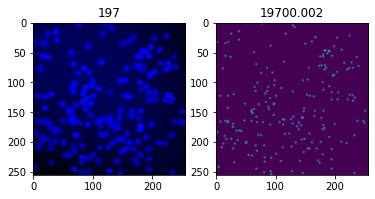

In [39]:
import matplotlib.pyplot as plt
sample = dataset_val[1]
img = sample[0].transpose(1,2,0)
dmap = sample[1].squeeze()
cnt = sample[2]
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(img)
ax[1].imshow(dmap)
ax[0].set_title(cnt)
ax[1].set_title(dmap.sum())

In [40]:
model.eval()
dmap, out_cnt = model(torch.tensor(sample[0]).unsqueeze(0).to(device))

In [41]:
out_cnt = out_cnt.detach().cpu().item()
dmap = dmap.detach().cpu().numpy()

Text(0.5, 1.0, 'Target: 197, regr: 231.4, map_int: 214.4')

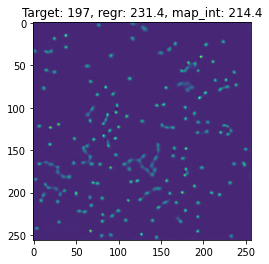

In [42]:
plt.imshow(dmap.squeeze())
plt.title(f"Target: {cnt}, regr: {out_cnt:.1f}, map_int: {dmap.sum()/100:.1f}")

In [43]:
preds, trgts = [], []
model.eval()
with torch.no_grad():
  for (img, maps, cnts) in dataset_val:
    imgs = torch.tensor(img).unsqueeze(0).to(device)
    dmap, reg = model(imgs)
    trgts.append(cnts)
    preds.append(dmap.sum().item()/100)


ValueError: ignored

In [ ]:
import numpy as np
preds = np.array(preds)
trgts = np.array(trgts)

In [ ]:
np.abs(preds - trgts).mean()